#### Imports

In [ ]:
import numpy as np
import gym
import tensorflow as tf
import random
import datetime
from collections import deque
import matplotlib.pyplot as plt
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import Huber
from tensorflow.keras.models import load_model

#### Environment

In [ ]:
### function to return the environment object, given the environment name
def environment_init(env_name):
    env  = gym.make(env_name)
    env.reset()
    return env

#### Agent

In [ ]:

class Agent:
    '''
    Agent Class which implements DQN, DDQN

    implements the following methods - 

    create_model : creates a feedforward neural network, which has input
                   size as the shape of the environment, and output size equal 
                   to the action space of the environment

    initialize_buffer: Initializes the replay memory

    add_to_buffer: Adds to the replay memory

    target_update: Updates the weight of the target network using the weights
                   of the primary network
    
    take_action : Takes one action in the environment using epsilon greedy policy
                  and adds that transition to the replay memory.

    train_v2    : Samples from the replay memory, implements the DQN and DDQN,
                  trains on the samples using the chosen algorithm.         
        
    run         : main caller function, calls other functions to implement the
                  logic
                  calls target_update, take_action, train_v2
                  Also stores rewards per epoch for plotting and does epsilon
                  decay after fixed number of steps.
    '''
    def __init__(self, env, config):
        
        
        self.gamma = config['GAMMA']
        self.epochs = config['EPOCHS']
        self.target_update_steps = config['TARGET_UPDATE']
        self.env = env
        self.epsilon = config['EPSILON']
        self.epsilon_decay = config['EPSILON_DECAY']
        self.buffer_size = config['REPLAY_BUFFER_SIZE']
        self.initial_buffer_size = config['INITIAL_BUFFER_SIZE']
        self.replay_buffer = deque(maxlen = config['REPLAY_BUFFER_SIZE'])
        self.n_actions = self.env.action_space.n 
        self.state_shape = self.env.observation_space.shape[0] 
        self.q_primary = self.create_model()
        self.q_target = self.create_model()
        self.epoch_rewards = []
        self.tau = config['TAU']

    def target_update(self):
      '''
      Updates the weights of the target network every 'self.target_update_steps'
      using 'self.tau' to adjust the extent of updates

      '''
        weights = self.q_primary.get_weights()
        target_weights = self.q_target.get_weights()
        
        for i in range(len(target_weights)):
            target_weights[i] = weights[i] * self.tau + target_weights[i] * (1 - self.tau)
        self.q_target.set_weights(target_weights)
        
    
    def create_model(self):
        '''
        creates the model with input shape equal to the number of states in the
        environment and output shape equal to the number of actions in the 
        environment

        '''
        model = Sequential()
        model.add(Dense(50, activation = 'relu',input_shape = (self.state_shape,)))
                       # kernel_initializer = 'glorot_normal'))
        model.add(Dense(50, activation = 'relu'))#, kernel_initializer = 'glorot_normal'))
        model.add(Dense(20, activation = 'relu'))#, kernel_initializer = 'glorot_normal'))

        model.add(Dense(self.n_actions))
        
        opt = Adam(config['LEARNING_RATE'])
    
        model.compile(opt,loss=Huber())
        
        return model
    
    def add_to_buffer(self, transition):
      '''
      adds to the replay memory

      '''
        self.replay_buffer.append(transition)
        

    def initialize_buffer(self):
        '''
        initializes the replay memory
        
        '''
        current_state  = self.env.reset()
        step = 0
        for i in range(self.initial_buffer_size):
            
            step+=1
            a = self.env.action_space.sample()
            next_state, reward, done, _ = self.env.step(a)
            
            ### Altering reward slightly, awarding a negative value for the
            ### terminal state for better learning

            if done and (self.env.unwrapped.spec.id == 'CartPole-v0' or self.env.unwrapped.spec.id == 'CartPole-v1'):
                reward  = config['NEGATIVE_REWARD']
            
            transition = np.array(list(current_state)+[a] + [reward] + list(next_state) + [done])
            
            self.replay_buffer.append(transition)
            
            current_state = next_state
            
            if done:

                current_state  = self.env.reset()
                step = 0
        
    def take_action(self, current_state):
        '''
        takes one action in the environment using epsilon greedy policy,
        stores the transition in the replay memory
        '''
        action = None
        if np.random.uniform() > self.epsilon:
            
            
            current_state_reshaped = current_state.reshape(1,self.state_shape)
            
            q_predicted = self.q_primary.predict(current_state_reshaped)
            ## Choosing Max Action
            max_action = np.argmax(q_predicted).squeeze()
            
            action = max_action
        
        else:
            ## Choosing Random Action
            action = self.env.action_space.sample()

        ### taking action in the environment  
        next_state, reward, done, _ = self.env.step(action)
        
        ### Altering reward slightly, awarding a negative value for the
        ### terminal state for better learning
        if done and (self.env.unwrapped.spec.id == 'CartPole-v0' or self.env.unwrapped.spec.id == 'CartPole-v1'):
                reward  = config['NEGATIVE_REWARD']

        transition = np.array(list(current_state)+[action] + [reward] + list(next_state) + [done])
       
        ### adding the transition to replay memory       
        self.add_to_buffer(transition)
        
        return done, reward, next_state, action
        
    
    def train_v2(self, algo = 'dqn'):
      '''
      implements dqn and ddqn, trains on the samples using the chosen algo

      '''

        ## sampling from replay memory
        samples = np.array(random.sample(self.replay_buffer,config['BATCH_SIZE']))
        
        ### extracting various components from the stored transitions
        if self.env.unwrapped.spec.id == 'CartPole-v0' or self.env.unwrapped.spec.id == 'CartPole-v1' :
        
                current_states = samples[:,:4]

                actions = samples[:,4]

                rewards = samples[:,5]
                
                next_states = samples[:,6:10]
                
                is_terminal = samples[:,10]

        
        ### Target for the current state
        Q_values = self.q_target.predict(current_states)
        
        ### Implementing DQN
        if algo == 'dqn':

            ### max q value for the next states from the target network 
            Q_max_next_states = np.max(self.q_target.predict(next_states), axis=1).squeeze()
            
            ### if terminal state the Q next = 0
            Q_max_next_states[is_terminal == 1] = 0

            td_target = rewards + self.gamma * Q_max_next_states
        
        ### Implementing DQN
        if algo == 'ddqn':
            
            ## max action(a') for the next state using the primary network
            ##  use a' with the target nextork using the next state
            
            ### extracting max action using the primary network on the next states
            max_action_primary = np.argmax(self.q_primary.predict(next_states), axis=1).squeeze()
            
            Q_next_states = self.q_target.predict(next_states)
            
            
            max_action_index = tuple(np.vstack((np.arange(config['BATCH_SIZE']), max_action_primary.astype('int'))))
            
            ### Taking Q value of the target network corresponding to the max 
            ### action from primary network

            Q_target = Q_next_states[max_action_index]

            ### if terminal state the Q next = 0
            Q_target[is_terminal == 1] = 0
            
            td_target = rewards + self.gamma * Q_target
            
        
        action_mask = tuple(np.vstack((np.arange(config['BATCH_SIZE']), actions.astype('int'))))
        
        ### updating the Q values for the target network for the actions in the 
        ### transition, setting it to the calculated td target

        Q_values[action_mask] = td_target

        ### using the target Q values to train the primary network
        self.q_primary.fit(current_states,Q_values,verbose=0)

    
    def load_model(self,model_name):
        '''
        load the model, used for experiments
        '''
        self.q_primary = load_model(save_path+"models/" + model_name)
        self.q_target = load_model(save_path+"models/"  + model_name)
        
        self.epsilon = EPSILON_MIN
        
    def save_model(self, model_name = 'default'):
      '''
        save the model, used for experiments
      '''
        self.q_primary.save(save_path+'models/{}-{}'.format(model_name,datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")))
        
    
    def run(self,algo):
      '''
      Takes as input the algo to be used. "dqn" or "ddqn"
      
      does target update and epsilon decay
      calls the take_action and train_v2 functions 
      
      '''
  
        for epoch in range(0,self.epochs+1):
            
            if epoch % self.target_update_steps == 0:
                self.target_update()
     
            
            current_state  = self.env.reset()
            epoch_reward = 0
            epoch_step = 0
           
            ### Until terminal state is reached
            while True:
                
                epoch_step+=1
                is_done, reward, next_state, action = self.take_action(current_state)  
      
                epoch_reward += reward
                current_state = next_state
                
                self.train_v2(algo)
                
                if is_done:
                  self.epoch_rewards.append(epoch_reward)
                  break
                    
            
            if epoch % config['DECAY_AFTER_EPOCHS'] == 0:
                 
    
                self.epsilon = self.epsilon * self.epsilon_decay
                self.epsilon = max(self.epsilon,config['EPSILON_MIN'])

            if epoch % 100 == 0 and epoch != 0:
                print('Episodes Done {}\n'.format(epoch))
                
                print(self.epoch_rewards)
                print()
                plt.plot(self.epoch_rewards)
                plt.show()
       

In [ ]:
#### Function used to run experiments for hyperparameter tuning
# Usage: run_experiments(config,'LEARNING_RATE',[0.0001,0.0002,0.0003],'small_learning_rate')
def run_experiments(config, algo, env_name, parameter, values, exp_name):
    
    for val in values:
        
        config[parameter] = val
        print('Parameter {} Value {} \n'.format(parameter, val))
        
        
        env = environment_init(env_name)
        agent = Agent(env, config)
        
        agent.initialize_buffer()
        
        agent.run(algo)
        
        # agent.save_model(exp_name+'-'+parameter+'-'+str(val))
        # fname = exp_name+'-'+parameter+'-'+str(val)+\
        #                    datetime.datetime.now().strftime("-%Y-%m-%d_%H-%M-%S")
            
        # config_file = open(save_path+'configs/'+fname+'.txt','w')
        # config_file.write(str(config))
        # config_file.close()
        
        # np.savetxt(save_path+'rewards/'+fname+'.txt',agent.epoch_rewards,fmt = '%d' )

        
  

In [ ]:
### Function used to run a particular config of hyperparameters on a given
### environment using a particular algo

def run_config(config, env_name, algo):
    env = environment_init(env_name)
    agent = Agent(env, config)

    agent.initialize_buffer()

    agent.run(algo)

    #agent.save_model()

    #drive.mount('/content/drive', force_remount=True)

    #config_file = open(save_path+'configs/'+datetime.datetime.now().
    #                 strftime("-%Y-%m-%d_%H-%M-%S")+'.txt','x')

    #config_file.write(str(config))
    #config_file.close()

    #np.savetxt(save_path+'rewards/'+datetime.datetime.now().
    #          strftime("-%Y-%m-%d_%H-%M-%S")+'.txt',agent.epoch_rewards,fmt = '%d' )
  
    return agent



**Benefit of using experience replay :**

Experience replay is used to remove correlation among
succesive samples of the environment, hence helps in learning a better Q function approximation, which is able to generalize better.

**Benefit of the target network :**

Target network gives a goal to move towards. It is thus used to train the primary network.

**One Benefit of representing the Q function as q(s,w) :** 

By using this form, we need not input each action to get it's Q value, we can simply call the q function using the state s and get q values for all the actions.

**DQN on CartPole-v0**

In [ ]:
config = {
    
    'BATCH_SIZE' : 32,
    'LEARNING_RATE' : 0.0001,
    'EPOCHS' : 800,
    'TARGET_UPDATE' : 3,
    'REPLAY_BUFFER_SIZE' : 5000,
    'INITIAL_BUFFER_SIZE' : 500,
    'EPSILON' : 0.95,
    'EPSILON_MIN' : 0.05,
    'EPSILON_DECAY' : 0.8,
    'DECAY_AFTER_EPOCHS'  : 16,
    'NEGATIVE_REWARD' : -5,
    'GAMMA' : 0.8,
    'TAU':1
}

Episodes Done 100

[9.0, 34.0, 21.0, 29.0, 19.0, 16.0, 10.0, 30.0, 6.0, 11.0, 19.0, 8.0, 11.0, 17.0, 6.0, 11.0, 10.0, 14.0, 3.0, 7.0, 35.0, 5.0, 25.0, 6.0, 8.0, 7.0, 6.0, 16.0, 6.0, 11.0, 13.0, 4.0, 22.0, 3.0, 3.0, 3.0, 3.0, 5.0, 12.0, 6.0, 5.0, 14.0, 6.0, 7.0, 6.0, 4.0, 5.0, 9.0, 11.0, 11.0, 7.0, 6.0, 4.0, 8.0, 5.0, 3.0, 6.0, 8.0, 4.0, 5.0, 11.0, 5.0, 5.0, 5.0, 6.0, 6.0, 4.0, 4.0, 6.0, 2.0, 6.0, 9.0, 2.0, 4.0, 6.0, 5.0, 2.0, 8.0, 3.0, 7.0, 5.0, 9.0, 3.0, 3.0, 4.0, 3.0, 4.0, 5.0, 6.0, 4.0, 6.0, 4.0, 5.0, 4.0, 3.0, 6.0, 8.0, 3.0, 2.0, 3.0, 4.0]



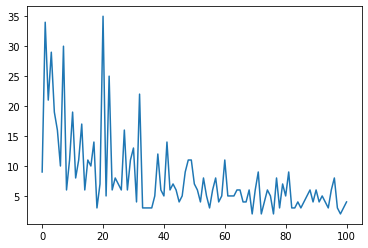

Episodes Done 200

[9.0, 34.0, 21.0, 29.0, 19.0, 16.0, 10.0, 30.0, 6.0, 11.0, 19.0, 8.0, 11.0, 17.0, 6.0, 11.0, 10.0, 14.0, 3.0, 7.0, 35.0, 5.0, 25.0, 6.0, 8.0, 7.0, 6.0, 16.0, 6.0, 11.0, 13.0, 4.0, 22.0, 3.0, 3.0, 3.0, 3.0, 5.0, 12.0, 6.0, 5.0, 14.0, 6.0, 7.0, 6.0, 4.0, 5.0, 9.0, 11.0, 11.0, 7.0, 6.0, 4.0, 8.0, 5.0, 3.0, 6.0, 8.0, 4.0, 5.0, 11.0, 5.0, 5.0, 5.0, 6.0, 6.0, 4.0, 4.0, 6.0, 2.0, 6.0, 9.0, 2.0, 4.0, 6.0, 5.0, 2.0, 8.0, 3.0, 7.0, 5.0, 9.0, 3.0, 3.0, 4.0, 3.0, 4.0, 5.0, 6.0, 4.0, 6.0, 4.0, 5.0, 4.0, 3.0, 6.0, 8.0, 3.0, 2.0, 3.0, 4.0, 5.0, 2.0, 4.0, 4.0, 5.0, 5.0, 4.0, 2.0, 5.0, 5.0, 3.0, 9.0, 2.0, 5.0, 4.0, 7.0, 4.0, 4.0, 4.0, 3.0, 5.0, 3.0, 5.0, 2.0, 5.0, 5.0, 4.0, 6.0, 4.0, 3.0, 5.0, 6.0, 5.0, 4.0, 3.0, 4.0, 6.0, 2.0, 4.0, 4.0, 3.0, 3.0, 3.0, 3.0, 5.0, 2.0, 3.0, 4.0, 4.0, 4.0, 3.0, 3.0, 5.0, 3.0, 2.0, 3.0, 3.0, 5.0, 2.0, 4.0, 4.0, 4.0, 3.0, 2.0, 4.0, 4.0, 4.0, 4.0, 3.0, 4.0, 3.0, 5.0, 3.0, 4.0, 3.0, 4.0, 5.0, 6.0, 6.0, 5.0, 8.0, 5.0, 10.0, 6.0, 8.0, 6.0, 6.0, 8.0, 8.0, 8.0,

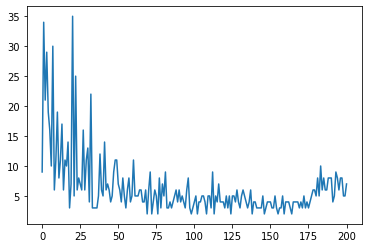

Episodes Done 300

[9.0, 34.0, 21.0, 29.0, 19.0, 16.0, 10.0, 30.0, 6.0, 11.0, 19.0, 8.0, 11.0, 17.0, 6.0, 11.0, 10.0, 14.0, 3.0, 7.0, 35.0, 5.0, 25.0, 6.0, 8.0, 7.0, 6.0, 16.0, 6.0, 11.0, 13.0, 4.0, 22.0, 3.0, 3.0, 3.0, 3.0, 5.0, 12.0, 6.0, 5.0, 14.0, 6.0, 7.0, 6.0, 4.0, 5.0, 9.0, 11.0, 11.0, 7.0, 6.0, 4.0, 8.0, 5.0, 3.0, 6.0, 8.0, 4.0, 5.0, 11.0, 5.0, 5.0, 5.0, 6.0, 6.0, 4.0, 4.0, 6.0, 2.0, 6.0, 9.0, 2.0, 4.0, 6.0, 5.0, 2.0, 8.0, 3.0, 7.0, 5.0, 9.0, 3.0, 3.0, 4.0, 3.0, 4.0, 5.0, 6.0, 4.0, 6.0, 4.0, 5.0, 4.0, 3.0, 6.0, 8.0, 3.0, 2.0, 3.0, 4.0, 5.0, 2.0, 4.0, 4.0, 5.0, 5.0, 4.0, 2.0, 5.0, 5.0, 3.0, 9.0, 2.0, 5.0, 4.0, 7.0, 4.0, 4.0, 4.0, 3.0, 5.0, 3.0, 5.0, 2.0, 5.0, 5.0, 4.0, 6.0, 4.0, 3.0, 5.0, 6.0, 5.0, 4.0, 3.0, 4.0, 6.0, 2.0, 4.0, 4.0, 3.0, 3.0, 3.0, 3.0, 5.0, 2.0, 3.0, 4.0, 4.0, 4.0, 3.0, 3.0, 5.0, 3.0, 2.0, 3.0, 3.0, 5.0, 2.0, 4.0, 4.0, 4.0, 3.0, 2.0, 4.0, 4.0, 4.0, 4.0, 3.0, 4.0, 3.0, 5.0, 3.0, 4.0, 3.0, 4.0, 5.0, 6.0, 6.0, 5.0, 8.0, 5.0, 10.0, 6.0, 8.0, 6.0, 6.0, 8.0, 8.0, 8.0,

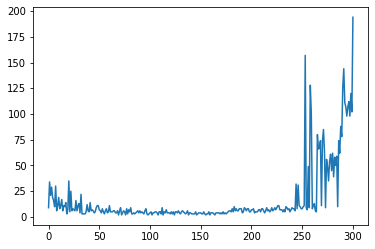

Episodes Done 400

[9.0, 34.0, 21.0, 29.0, 19.0, 16.0, 10.0, 30.0, 6.0, 11.0, 19.0, 8.0, 11.0, 17.0, 6.0, 11.0, 10.0, 14.0, 3.0, 7.0, 35.0, 5.0, 25.0, 6.0, 8.0, 7.0, 6.0, 16.0, 6.0, 11.0, 13.0, 4.0, 22.0, 3.0, 3.0, 3.0, 3.0, 5.0, 12.0, 6.0, 5.0, 14.0, 6.0, 7.0, 6.0, 4.0, 5.0, 9.0, 11.0, 11.0, 7.0, 6.0, 4.0, 8.0, 5.0, 3.0, 6.0, 8.0, 4.0, 5.0, 11.0, 5.0, 5.0, 5.0, 6.0, 6.0, 4.0, 4.0, 6.0, 2.0, 6.0, 9.0, 2.0, 4.0, 6.0, 5.0, 2.0, 8.0, 3.0, 7.0, 5.0, 9.0, 3.0, 3.0, 4.0, 3.0, 4.0, 5.0, 6.0, 4.0, 6.0, 4.0, 5.0, 4.0, 3.0, 6.0, 8.0, 3.0, 2.0, 3.0, 4.0, 5.0, 2.0, 4.0, 4.0, 5.0, 5.0, 4.0, 2.0, 5.0, 5.0, 3.0, 9.0, 2.0, 5.0, 4.0, 7.0, 4.0, 4.0, 4.0, 3.0, 5.0, 3.0, 5.0, 2.0, 5.0, 5.0, 4.0, 6.0, 4.0, 3.0, 5.0, 6.0, 5.0, 4.0, 3.0, 4.0, 6.0, 2.0, 4.0, 4.0, 3.0, 3.0, 3.0, 3.0, 5.0, 2.0, 3.0, 4.0, 4.0, 4.0, 3.0, 3.0, 5.0, 3.0, 2.0, 3.0, 3.0, 5.0, 2.0, 4.0, 4.0, 4.0, 3.0, 2.0, 4.0, 4.0, 4.0, 4.0, 3.0, 4.0, 3.0, 5.0, 3.0, 4.0, 3.0, 4.0, 5.0, 6.0, 6.0, 5.0, 8.0, 5.0, 10.0, 6.0, 8.0, 6.0, 6.0, 8.0, 8.0, 8.0,

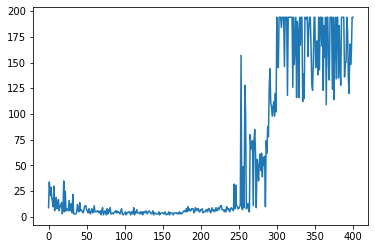

Episodes Done 500

[9.0, 34.0, 21.0, 29.0, 19.0, 16.0, 10.0, 30.0, 6.0, 11.0, 19.0, 8.0, 11.0, 17.0, 6.0, 11.0, 10.0, 14.0, 3.0, 7.0, 35.0, 5.0, 25.0, 6.0, 8.0, 7.0, 6.0, 16.0, 6.0, 11.0, 13.0, 4.0, 22.0, 3.0, 3.0, 3.0, 3.0, 5.0, 12.0, 6.0, 5.0, 14.0, 6.0, 7.0, 6.0, 4.0, 5.0, 9.0, 11.0, 11.0, 7.0, 6.0, 4.0, 8.0, 5.0, 3.0, 6.0, 8.0, 4.0, 5.0, 11.0, 5.0, 5.0, 5.0, 6.0, 6.0, 4.0, 4.0, 6.0, 2.0, 6.0, 9.0, 2.0, 4.0, 6.0, 5.0, 2.0, 8.0, 3.0, 7.0, 5.0, 9.0, 3.0, 3.0, 4.0, 3.0, 4.0, 5.0, 6.0, 4.0, 6.0, 4.0, 5.0, 4.0, 3.0, 6.0, 8.0, 3.0, 2.0, 3.0, 4.0, 5.0, 2.0, 4.0, 4.0, 5.0, 5.0, 4.0, 2.0, 5.0, 5.0, 3.0, 9.0, 2.0, 5.0, 4.0, 7.0, 4.0, 4.0, 4.0, 3.0, 5.0, 3.0, 5.0, 2.0, 5.0, 5.0, 4.0, 6.0, 4.0, 3.0, 5.0, 6.0, 5.0, 4.0, 3.0, 4.0, 6.0, 2.0, 4.0, 4.0, 3.0, 3.0, 3.0, 3.0, 5.0, 2.0, 3.0, 4.0, 4.0, 4.0, 3.0, 3.0, 5.0, 3.0, 2.0, 3.0, 3.0, 5.0, 2.0, 4.0, 4.0, 4.0, 3.0, 2.0, 4.0, 4.0, 4.0, 4.0, 3.0, 4.0, 3.0, 5.0, 3.0, 4.0, 3.0, 4.0, 5.0, 6.0, 6.0, 5.0, 8.0, 5.0, 10.0, 6.0, 8.0, 6.0, 6.0, 8.0, 8.0, 8.0,

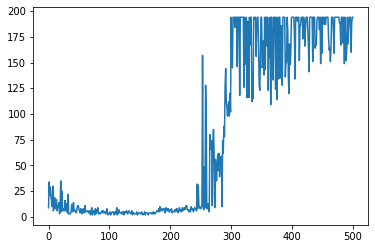

Episodes Done 600

[9.0, 34.0, 21.0, 29.0, 19.0, 16.0, 10.0, 30.0, 6.0, 11.0, 19.0, 8.0, 11.0, 17.0, 6.0, 11.0, 10.0, 14.0, 3.0, 7.0, 35.0, 5.0, 25.0, 6.0, 8.0, 7.0, 6.0, 16.0, 6.0, 11.0, 13.0, 4.0, 22.0, 3.0, 3.0, 3.0, 3.0, 5.0, 12.0, 6.0, 5.0, 14.0, 6.0, 7.0, 6.0, 4.0, 5.0, 9.0, 11.0, 11.0, 7.0, 6.0, 4.0, 8.0, 5.0, 3.0, 6.0, 8.0, 4.0, 5.0, 11.0, 5.0, 5.0, 5.0, 6.0, 6.0, 4.0, 4.0, 6.0, 2.0, 6.0, 9.0, 2.0, 4.0, 6.0, 5.0, 2.0, 8.0, 3.0, 7.0, 5.0, 9.0, 3.0, 3.0, 4.0, 3.0, 4.0, 5.0, 6.0, 4.0, 6.0, 4.0, 5.0, 4.0, 3.0, 6.0, 8.0, 3.0, 2.0, 3.0, 4.0, 5.0, 2.0, 4.0, 4.0, 5.0, 5.0, 4.0, 2.0, 5.0, 5.0, 3.0, 9.0, 2.0, 5.0, 4.0, 7.0, 4.0, 4.0, 4.0, 3.0, 5.0, 3.0, 5.0, 2.0, 5.0, 5.0, 4.0, 6.0, 4.0, 3.0, 5.0, 6.0, 5.0, 4.0, 3.0, 4.0, 6.0, 2.0, 4.0, 4.0, 3.0, 3.0, 3.0, 3.0, 5.0, 2.0, 3.0, 4.0, 4.0, 4.0, 3.0, 3.0, 5.0, 3.0, 2.0, 3.0, 3.0, 5.0, 2.0, 4.0, 4.0, 4.0, 3.0, 2.0, 4.0, 4.0, 4.0, 4.0, 3.0, 4.0, 3.0, 5.0, 3.0, 4.0, 3.0, 4.0, 5.0, 6.0, 6.0, 5.0, 8.0, 5.0, 10.0, 6.0, 8.0, 6.0, 6.0, 8.0, 8.0, 8.0,

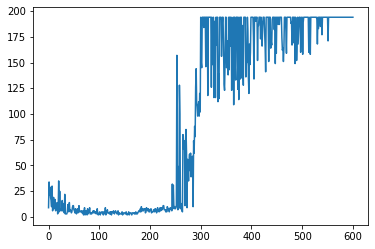

Episodes Done 700

[9.0, 34.0, 21.0, 29.0, 19.0, 16.0, 10.0, 30.0, 6.0, 11.0, 19.0, 8.0, 11.0, 17.0, 6.0, 11.0, 10.0, 14.0, 3.0, 7.0, 35.0, 5.0, 25.0, 6.0, 8.0, 7.0, 6.0, 16.0, 6.0, 11.0, 13.0, 4.0, 22.0, 3.0, 3.0, 3.0, 3.0, 5.0, 12.0, 6.0, 5.0, 14.0, 6.0, 7.0, 6.0, 4.0, 5.0, 9.0, 11.0, 11.0, 7.0, 6.0, 4.0, 8.0, 5.0, 3.0, 6.0, 8.0, 4.0, 5.0, 11.0, 5.0, 5.0, 5.0, 6.0, 6.0, 4.0, 4.0, 6.0, 2.0, 6.0, 9.0, 2.0, 4.0, 6.0, 5.0, 2.0, 8.0, 3.0, 7.0, 5.0, 9.0, 3.0, 3.0, 4.0, 3.0, 4.0, 5.0, 6.0, 4.0, 6.0, 4.0, 5.0, 4.0, 3.0, 6.0, 8.0, 3.0, 2.0, 3.0, 4.0, 5.0, 2.0, 4.0, 4.0, 5.0, 5.0, 4.0, 2.0, 5.0, 5.0, 3.0, 9.0, 2.0, 5.0, 4.0, 7.0, 4.0, 4.0, 4.0, 3.0, 5.0, 3.0, 5.0, 2.0, 5.0, 5.0, 4.0, 6.0, 4.0, 3.0, 5.0, 6.0, 5.0, 4.0, 3.0, 4.0, 6.0, 2.0, 4.0, 4.0, 3.0, 3.0, 3.0, 3.0, 5.0, 2.0, 3.0, 4.0, 4.0, 4.0, 3.0, 3.0, 5.0, 3.0, 2.0, 3.0, 3.0, 5.0, 2.0, 4.0, 4.0, 4.0, 3.0, 2.0, 4.0, 4.0, 4.0, 4.0, 3.0, 4.0, 3.0, 5.0, 3.0, 4.0, 3.0, 4.0, 5.0, 6.0, 6.0, 5.0, 8.0, 5.0, 10.0, 6.0, 8.0, 6.0, 6.0, 8.0, 8.0, 8.0,

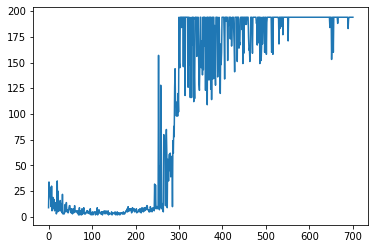

Episodes Done 800

[9.0, 34.0, 21.0, 29.0, 19.0, 16.0, 10.0, 30.0, 6.0, 11.0, 19.0, 8.0, 11.0, 17.0, 6.0, 11.0, 10.0, 14.0, 3.0, 7.0, 35.0, 5.0, 25.0, 6.0, 8.0, 7.0, 6.0, 16.0, 6.0, 11.0, 13.0, 4.0, 22.0, 3.0, 3.0, 3.0, 3.0, 5.0, 12.0, 6.0, 5.0, 14.0, 6.0, 7.0, 6.0, 4.0, 5.0, 9.0, 11.0, 11.0, 7.0, 6.0, 4.0, 8.0, 5.0, 3.0, 6.0, 8.0, 4.0, 5.0, 11.0, 5.0, 5.0, 5.0, 6.0, 6.0, 4.0, 4.0, 6.0, 2.0, 6.0, 9.0, 2.0, 4.0, 6.0, 5.0, 2.0, 8.0, 3.0, 7.0, 5.0, 9.0, 3.0, 3.0, 4.0, 3.0, 4.0, 5.0, 6.0, 4.0, 6.0, 4.0, 5.0, 4.0, 3.0, 6.0, 8.0, 3.0, 2.0, 3.0, 4.0, 5.0, 2.0, 4.0, 4.0, 5.0, 5.0, 4.0, 2.0, 5.0, 5.0, 3.0, 9.0, 2.0, 5.0, 4.0, 7.0, 4.0, 4.0, 4.0, 3.0, 5.0, 3.0, 5.0, 2.0, 5.0, 5.0, 4.0, 6.0, 4.0, 3.0, 5.0, 6.0, 5.0, 4.0, 3.0, 4.0, 6.0, 2.0, 4.0, 4.0, 3.0, 3.0, 3.0, 3.0, 5.0, 2.0, 3.0, 4.0, 4.0, 4.0, 3.0, 3.0, 5.0, 3.0, 2.0, 3.0, 3.0, 5.0, 2.0, 4.0, 4.0, 4.0, 3.0, 2.0, 4.0, 4.0, 4.0, 4.0, 3.0, 4.0, 3.0, 5.0, 3.0, 4.0, 3.0, 4.0, 5.0, 6.0, 6.0, 5.0, 8.0, 5.0, 10.0, 6.0, 8.0, 6.0, 6.0, 8.0, 8.0, 8.0,

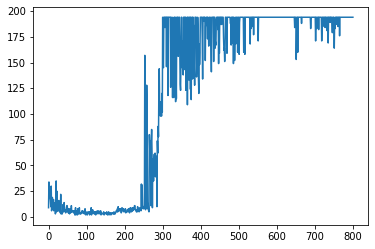

In [ ]:
agent = run_config(config,'CartPole-v0', 'dqn')

**DQN on CartPole-v1**

Difference from v0 is that the maximum steps threshold in v1 is 500 whereas it is 200 for v0, hence the maximum rewards are 195 and 495 respectively.

In [ ]:
cartpolev1_config = {
    
    'BATCH_SIZE' : 32,
    'LEARNING_RATE' : 0.000087,
    'EPOCHS' : 800,
    'TARGET_UPDATE' : 3,
    'REPLAY_BUFFER_SIZE' : 5000,
    'INITIAL_BUFFER_SIZE' : 500,
    'EPSILON' : 0.95,
    'EPSILON_MIN' : 0.05,
    'EPSILON_DECAY' : 0.8,
    'DECAY_AFTER_EPOCHS'  : 16,
    'NEGATIVE_REWARD' : -5,
    'GAMMA' : 0.8,
    'TAU':1
}

Episodes Done 100

[7.0, 14.0, 22.0, 11.0, 8.0, 7.0, 13.0, 8.0, 14.0, 19.0, 5.0, 15.0, 21.0, 27.0, 20.0, 7.0, 12.0, 10.0, 5.0, 5.0, 7.0, 11.0, 8.0, 3.0, 11.0, 17.0, 14.0, 12.0, 9.0, 8.0, 11.0, 3.0, 15.0, 5.0, 4.0, 9.0, 19.0, 6.0, 6.0, 10.0, 11.0, 3.0, 6.0, 7.0, 3.0, 7.0, 6.0, 5.0, 3.0, 6.0, 5.0, 6.0, 4.0, 5.0, 7.0, 4.0, 3.0, 3.0, 10.0, 2.0, 8.0, 4.0, 6.0, 5.0, 4.0, 4.0, 8.0, 5.0, 4.0, 3.0, 7.0, 4.0, 14.0, 6.0, 3.0, 4.0, 3.0, 7.0, 3.0, 3.0, 3.0, 12.0, 3.0, 5.0, 5.0, 4.0, 5.0, 4.0, 4.0, 5.0, 3.0, 7.0, 4.0, 11.0, 9.0, 6.0, 6.0, 5.0, 5.0, 3.0, 4.0]



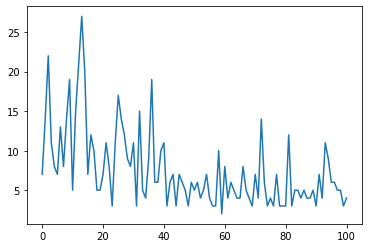

Episodes Done 200

[7.0, 14.0, 22.0, 11.0, 8.0, 7.0, 13.0, 8.0, 14.0, 19.0, 5.0, 15.0, 21.0, 27.0, 20.0, 7.0, 12.0, 10.0, 5.0, 5.0, 7.0, 11.0, 8.0, 3.0, 11.0, 17.0, 14.0, 12.0, 9.0, 8.0, 11.0, 3.0, 15.0, 5.0, 4.0, 9.0, 19.0, 6.0, 6.0, 10.0, 11.0, 3.0, 6.0, 7.0, 3.0, 7.0, 6.0, 5.0, 3.0, 6.0, 5.0, 6.0, 4.0, 5.0, 7.0, 4.0, 3.0, 3.0, 10.0, 2.0, 8.0, 4.0, 6.0, 5.0, 4.0, 4.0, 8.0, 5.0, 4.0, 3.0, 7.0, 4.0, 14.0, 6.0, 3.0, 4.0, 3.0, 7.0, 3.0, 3.0, 3.0, 12.0, 3.0, 5.0, 5.0, 4.0, 5.0, 4.0, 4.0, 5.0, 3.0, 7.0, 4.0, 11.0, 9.0, 6.0, 6.0, 5.0, 5.0, 3.0, 4.0, 6.0, 7.0, 5.0, 3.0, 5.0, 13.0, 7.0, 6.0, 8.0, 5.0, 7.0, 9.0, 7.0, 6.0, 5.0, 4.0, 5.0, 3.0, 10.0, 2.0, 4.0, 3.0, 7.0, 6.0, 4.0, 3.0, 2.0, 6.0, 3.0, 4.0, 3.0, 6.0, 5.0, 2.0, 4.0, 3.0, 3.0, 22.0, 5.0, 4.0, 2.0, 3.0, 3.0, 3.0, 3.0, 4.0, 6.0, 4.0, 4.0, 2.0, 3.0, 5.0, 7.0, 3.0, 5.0, 5.0, 3.0, 8.0, 4.0, 3.0, 3.0, 2.0, 3.0, 7.0, 5.0, 4.0, 8.0, 8.0, 8.0, 9.0, 6.0, 11.0, 5.0, 10.0, 7.0, 4.0, 6.0, 9.0, 7.0, 9.0, 7.0, 10.0, 11.0, 9.0, 9.0, 6.0, 11.0, 4.0, 3

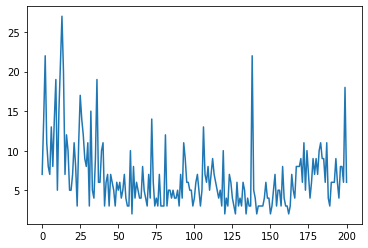

Episodes Done 300

[7.0, 14.0, 22.0, 11.0, 8.0, 7.0, 13.0, 8.0, 14.0, 19.0, 5.0, 15.0, 21.0, 27.0, 20.0, 7.0, 12.0, 10.0, 5.0, 5.0, 7.0, 11.0, 8.0, 3.0, 11.0, 17.0, 14.0, 12.0, 9.0, 8.0, 11.0, 3.0, 15.0, 5.0, 4.0, 9.0, 19.0, 6.0, 6.0, 10.0, 11.0, 3.0, 6.0, 7.0, 3.0, 7.0, 6.0, 5.0, 3.0, 6.0, 5.0, 6.0, 4.0, 5.0, 7.0, 4.0, 3.0, 3.0, 10.0, 2.0, 8.0, 4.0, 6.0, 5.0, 4.0, 4.0, 8.0, 5.0, 4.0, 3.0, 7.0, 4.0, 14.0, 6.0, 3.0, 4.0, 3.0, 7.0, 3.0, 3.0, 3.0, 12.0, 3.0, 5.0, 5.0, 4.0, 5.0, 4.0, 4.0, 5.0, 3.0, 7.0, 4.0, 11.0, 9.0, 6.0, 6.0, 5.0, 5.0, 3.0, 4.0, 6.0, 7.0, 5.0, 3.0, 5.0, 13.0, 7.0, 6.0, 8.0, 5.0, 7.0, 9.0, 7.0, 6.0, 5.0, 4.0, 5.0, 3.0, 10.0, 2.0, 4.0, 3.0, 7.0, 6.0, 4.0, 3.0, 2.0, 6.0, 3.0, 4.0, 3.0, 6.0, 5.0, 2.0, 4.0, 3.0, 3.0, 22.0, 5.0, 4.0, 2.0, 3.0, 3.0, 3.0, 3.0, 4.0, 6.0, 4.0, 4.0, 2.0, 3.0, 5.0, 7.0, 3.0, 5.0, 5.0, 3.0, 8.0, 4.0, 3.0, 3.0, 2.0, 3.0, 7.0, 5.0, 4.0, 8.0, 8.0, 8.0, 9.0, 6.0, 11.0, 5.0, 10.0, 7.0, 4.0, 6.0, 9.0, 7.0, 9.0, 7.0, 10.0, 11.0, 9.0, 9.0, 6.0, 11.0, 4.0, 3

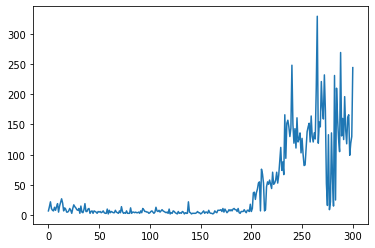

Episodes Done 400

[7.0, 14.0, 22.0, 11.0, 8.0, 7.0, 13.0, 8.0, 14.0, 19.0, 5.0, 15.0, 21.0, 27.0, 20.0, 7.0, 12.0, 10.0, 5.0, 5.0, 7.0, 11.0, 8.0, 3.0, 11.0, 17.0, 14.0, 12.0, 9.0, 8.0, 11.0, 3.0, 15.0, 5.0, 4.0, 9.0, 19.0, 6.0, 6.0, 10.0, 11.0, 3.0, 6.0, 7.0, 3.0, 7.0, 6.0, 5.0, 3.0, 6.0, 5.0, 6.0, 4.0, 5.0, 7.0, 4.0, 3.0, 3.0, 10.0, 2.0, 8.0, 4.0, 6.0, 5.0, 4.0, 4.0, 8.0, 5.0, 4.0, 3.0, 7.0, 4.0, 14.0, 6.0, 3.0, 4.0, 3.0, 7.0, 3.0, 3.0, 3.0, 12.0, 3.0, 5.0, 5.0, 4.0, 5.0, 4.0, 4.0, 5.0, 3.0, 7.0, 4.0, 11.0, 9.0, 6.0, 6.0, 5.0, 5.0, 3.0, 4.0, 6.0, 7.0, 5.0, 3.0, 5.0, 13.0, 7.0, 6.0, 8.0, 5.0, 7.0, 9.0, 7.0, 6.0, 5.0, 4.0, 5.0, 3.0, 10.0, 2.0, 4.0, 3.0, 7.0, 6.0, 4.0, 3.0, 2.0, 6.0, 3.0, 4.0, 3.0, 6.0, 5.0, 2.0, 4.0, 3.0, 3.0, 22.0, 5.0, 4.0, 2.0, 3.0, 3.0, 3.0, 3.0, 4.0, 6.0, 4.0, 4.0, 2.0, 3.0, 5.0, 7.0, 3.0, 5.0, 5.0, 3.0, 8.0, 4.0, 3.0, 3.0, 2.0, 3.0, 7.0, 5.0, 4.0, 8.0, 8.0, 8.0, 9.0, 6.0, 11.0, 5.0, 10.0, 7.0, 4.0, 6.0, 9.0, 7.0, 9.0, 7.0, 10.0, 11.0, 9.0, 9.0, 6.0, 11.0, 4.0, 3

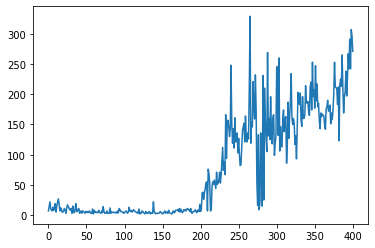

Episodes Done 500

[7.0, 14.0, 22.0, 11.0, 8.0, 7.0, 13.0, 8.0, 14.0, 19.0, 5.0, 15.0, 21.0, 27.0, 20.0, 7.0, 12.0, 10.0, 5.0, 5.0, 7.0, 11.0, 8.0, 3.0, 11.0, 17.0, 14.0, 12.0, 9.0, 8.0, 11.0, 3.0, 15.0, 5.0, 4.0, 9.0, 19.0, 6.0, 6.0, 10.0, 11.0, 3.0, 6.0, 7.0, 3.0, 7.0, 6.0, 5.0, 3.0, 6.0, 5.0, 6.0, 4.0, 5.0, 7.0, 4.0, 3.0, 3.0, 10.0, 2.0, 8.0, 4.0, 6.0, 5.0, 4.0, 4.0, 8.0, 5.0, 4.0, 3.0, 7.0, 4.0, 14.0, 6.0, 3.0, 4.0, 3.0, 7.0, 3.0, 3.0, 3.0, 12.0, 3.0, 5.0, 5.0, 4.0, 5.0, 4.0, 4.0, 5.0, 3.0, 7.0, 4.0, 11.0, 9.0, 6.0, 6.0, 5.0, 5.0, 3.0, 4.0, 6.0, 7.0, 5.0, 3.0, 5.0, 13.0, 7.0, 6.0, 8.0, 5.0, 7.0, 9.0, 7.0, 6.0, 5.0, 4.0, 5.0, 3.0, 10.0, 2.0, 4.0, 3.0, 7.0, 6.0, 4.0, 3.0, 2.0, 6.0, 3.0, 4.0, 3.0, 6.0, 5.0, 2.0, 4.0, 3.0, 3.0, 22.0, 5.0, 4.0, 2.0, 3.0, 3.0, 3.0, 3.0, 4.0, 6.0, 4.0, 4.0, 2.0, 3.0, 5.0, 7.0, 3.0, 5.0, 5.0, 3.0, 8.0, 4.0, 3.0, 3.0, 2.0, 3.0, 7.0, 5.0, 4.0, 8.0, 8.0, 8.0, 9.0, 6.0, 11.0, 5.0, 10.0, 7.0, 4.0, 6.0, 9.0, 7.0, 9.0, 7.0, 10.0, 11.0, 9.0, 9.0, 6.0, 11.0, 4.0, 3

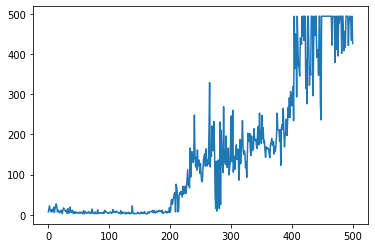

Episodes Done 600

[7.0, 14.0, 22.0, 11.0, 8.0, 7.0, 13.0, 8.0, 14.0, 19.0, 5.0, 15.0, 21.0, 27.0, 20.0, 7.0, 12.0, 10.0, 5.0, 5.0, 7.0, 11.0, 8.0, 3.0, 11.0, 17.0, 14.0, 12.0, 9.0, 8.0, 11.0, 3.0, 15.0, 5.0, 4.0, 9.0, 19.0, 6.0, 6.0, 10.0, 11.0, 3.0, 6.0, 7.0, 3.0, 7.0, 6.0, 5.0, 3.0, 6.0, 5.0, 6.0, 4.0, 5.0, 7.0, 4.0, 3.0, 3.0, 10.0, 2.0, 8.0, 4.0, 6.0, 5.0, 4.0, 4.0, 8.0, 5.0, 4.0, 3.0, 7.0, 4.0, 14.0, 6.0, 3.0, 4.0, 3.0, 7.0, 3.0, 3.0, 3.0, 12.0, 3.0, 5.0, 5.0, 4.0, 5.0, 4.0, 4.0, 5.0, 3.0, 7.0, 4.0, 11.0, 9.0, 6.0, 6.0, 5.0, 5.0, 3.0, 4.0, 6.0, 7.0, 5.0, 3.0, 5.0, 13.0, 7.0, 6.0, 8.0, 5.0, 7.0, 9.0, 7.0, 6.0, 5.0, 4.0, 5.0, 3.0, 10.0, 2.0, 4.0, 3.0, 7.0, 6.0, 4.0, 3.0, 2.0, 6.0, 3.0, 4.0, 3.0, 6.0, 5.0, 2.0, 4.0, 3.0, 3.0, 22.0, 5.0, 4.0, 2.0, 3.0, 3.0, 3.0, 3.0, 4.0, 6.0, 4.0, 4.0, 2.0, 3.0, 5.0, 7.0, 3.0, 5.0, 5.0, 3.0, 8.0, 4.0, 3.0, 3.0, 2.0, 3.0, 7.0, 5.0, 4.0, 8.0, 8.0, 8.0, 9.0, 6.0, 11.0, 5.0, 10.0, 7.0, 4.0, 6.0, 9.0, 7.0, 9.0, 7.0, 10.0, 11.0, 9.0, 9.0, 6.0, 11.0, 4.0, 3

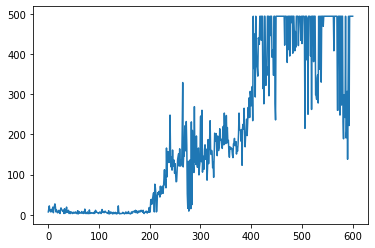

Episodes Done 700

[7.0, 14.0, 22.0, 11.0, 8.0, 7.0, 13.0, 8.0, 14.0, 19.0, 5.0, 15.0, 21.0, 27.0, 20.0, 7.0, 12.0, 10.0, 5.0, 5.0, 7.0, 11.0, 8.0, 3.0, 11.0, 17.0, 14.0, 12.0, 9.0, 8.0, 11.0, 3.0, 15.0, 5.0, 4.0, 9.0, 19.0, 6.0, 6.0, 10.0, 11.0, 3.0, 6.0, 7.0, 3.0, 7.0, 6.0, 5.0, 3.0, 6.0, 5.0, 6.0, 4.0, 5.0, 7.0, 4.0, 3.0, 3.0, 10.0, 2.0, 8.0, 4.0, 6.0, 5.0, 4.0, 4.0, 8.0, 5.0, 4.0, 3.0, 7.0, 4.0, 14.0, 6.0, 3.0, 4.0, 3.0, 7.0, 3.0, 3.0, 3.0, 12.0, 3.0, 5.0, 5.0, 4.0, 5.0, 4.0, 4.0, 5.0, 3.0, 7.0, 4.0, 11.0, 9.0, 6.0, 6.0, 5.0, 5.0, 3.0, 4.0, 6.0, 7.0, 5.0, 3.0, 5.0, 13.0, 7.0, 6.0, 8.0, 5.0, 7.0, 9.0, 7.0, 6.0, 5.0, 4.0, 5.0, 3.0, 10.0, 2.0, 4.0, 3.0, 7.0, 6.0, 4.0, 3.0, 2.0, 6.0, 3.0, 4.0, 3.0, 6.0, 5.0, 2.0, 4.0, 3.0, 3.0, 22.0, 5.0, 4.0, 2.0, 3.0, 3.0, 3.0, 3.0, 4.0, 6.0, 4.0, 4.0, 2.0, 3.0, 5.0, 7.0, 3.0, 5.0, 5.0, 3.0, 8.0, 4.0, 3.0, 3.0, 2.0, 3.0, 7.0, 5.0, 4.0, 8.0, 8.0, 8.0, 9.0, 6.0, 11.0, 5.0, 10.0, 7.0, 4.0, 6.0, 9.0, 7.0, 9.0, 7.0, 10.0, 11.0, 9.0, 9.0, 6.0, 11.0, 4.0, 3

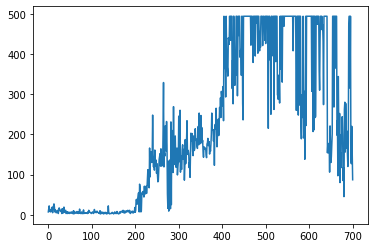

Episodes Done 800

[7.0, 14.0, 22.0, 11.0, 8.0, 7.0, 13.0, 8.0, 14.0, 19.0, 5.0, 15.0, 21.0, 27.0, 20.0, 7.0, 12.0, 10.0, 5.0, 5.0, 7.0, 11.0, 8.0, 3.0, 11.0, 17.0, 14.0, 12.0, 9.0, 8.0, 11.0, 3.0, 15.0, 5.0, 4.0, 9.0, 19.0, 6.0, 6.0, 10.0, 11.0, 3.0, 6.0, 7.0, 3.0, 7.0, 6.0, 5.0, 3.0, 6.0, 5.0, 6.0, 4.0, 5.0, 7.0, 4.0, 3.0, 3.0, 10.0, 2.0, 8.0, 4.0, 6.0, 5.0, 4.0, 4.0, 8.0, 5.0, 4.0, 3.0, 7.0, 4.0, 14.0, 6.0, 3.0, 4.0, 3.0, 7.0, 3.0, 3.0, 3.0, 12.0, 3.0, 5.0, 5.0, 4.0, 5.0, 4.0, 4.0, 5.0, 3.0, 7.0, 4.0, 11.0, 9.0, 6.0, 6.0, 5.0, 5.0, 3.0, 4.0, 6.0, 7.0, 5.0, 3.0, 5.0, 13.0, 7.0, 6.0, 8.0, 5.0, 7.0, 9.0, 7.0, 6.0, 5.0, 4.0, 5.0, 3.0, 10.0, 2.0, 4.0, 3.0, 7.0, 6.0, 4.0, 3.0, 2.0, 6.0, 3.0, 4.0, 3.0, 6.0, 5.0, 2.0, 4.0, 3.0, 3.0, 22.0, 5.0, 4.0, 2.0, 3.0, 3.0, 3.0, 3.0, 4.0, 6.0, 4.0, 4.0, 2.0, 3.0, 5.0, 7.0, 3.0, 5.0, 5.0, 3.0, 8.0, 4.0, 3.0, 3.0, 2.0, 3.0, 7.0, 5.0, 4.0, 8.0, 8.0, 8.0, 9.0, 6.0, 11.0, 5.0, 10.0, 7.0, 4.0, 6.0, 9.0, 7.0, 9.0, 7.0, 10.0, 11.0, 9.0, 9.0, 6.0, 11.0, 4.0, 3

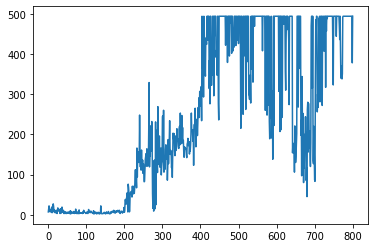

In [ ]:
agent_dqn_v1 = run_config(cartpolev1_config,'CartPole-v1', 'dqn')

Comments: The rewards increase with time and in the last few epochs the agent is solving the environment fairly consistently, but there is still variance.  More Hypterparameter tuning will result in lesser variance of the reward

**DDQN on CartPole-v0**

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Episodes Done 100

[32.0, 32.0, 3.0, 18.0, 42.0, 18.0, 9.0, 11.0, 4.0, 12.0, 17.0, 5.0, 16.0, 36.0, 26.0, 41.0, 5.0, 10.0, 5.0, 21.0, 2.0, 13.0, 6.0, 8.0, 3.0, 4.0, 9.0, 7.0, 17.0, 8.0, 6.0, 19.0, 9.0, 5.0, 10.0, 26.0, 5.0, 8.0, 8.0, 10.0, 5.0, 6.0, 18.0, 8.0, 3.0, 6.0, 13.0, 17.0, 6.0, 10.0, 4.0, 4.0, 9.0, 10.0, 3.0, 7.0, 4.0, 5.0, 5.0, 2.0, 7.0, 9.0, 3.0, 9.0, 5.0, 7.0, 5.0, 6.0, 3.0, 2.0, 5.0, 4.0, 7.0, 4.0, 3.0, 4.0, 7.0, 4.0, 7.0, 6.0, 5.0, 5.0, 6.0, 5.0, 5.0, 5.0, 4.0, 3.0, 5.0, 7.0, 3.0, 3.0, 4.0, 3.0, 4.0, 4.0, 4.0, 3.0, 3.0, 6.0, 4.0]



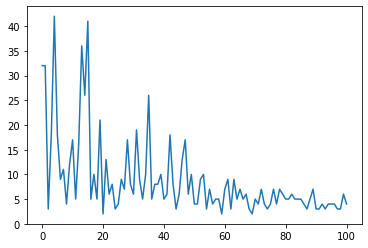

Episodes Done 200

[32.0, 32.0, 3.0, 18.0, 42.0, 18.0, 9.0, 11.0, 4.0, 12.0, 17.0, 5.0, 16.0, 36.0, 26.0, 41.0, 5.0, 10.0, 5.0, 21.0, 2.0, 13.0, 6.0, 8.0, 3.0, 4.0, 9.0, 7.0, 17.0, 8.0, 6.0, 19.0, 9.0, 5.0, 10.0, 26.0, 5.0, 8.0, 8.0, 10.0, 5.0, 6.0, 18.0, 8.0, 3.0, 6.0, 13.0, 17.0, 6.0, 10.0, 4.0, 4.0, 9.0, 10.0, 3.0, 7.0, 4.0, 5.0, 5.0, 2.0, 7.0, 9.0, 3.0, 9.0, 5.0, 7.0, 5.0, 6.0, 3.0, 2.0, 5.0, 4.0, 7.0, 4.0, 3.0, 4.0, 7.0, 4.0, 7.0, 6.0, 5.0, 5.0, 6.0, 5.0, 5.0, 5.0, 4.0, 3.0, 5.0, 7.0, 3.0, 3.0, 4.0, 3.0, 4.0, 4.0, 4.0, 3.0, 3.0, 6.0, 4.0, 7.0, 4.0, 4.0, 3.0, 3.0, 3.0, 4.0, 5.0, 3.0, 6.0, 3.0, 4.0, 4.0, 3.0, 4.0, 4.0, 3.0, 8.0, 5.0, 6.0, 5.0, 3.0, 6.0, 2.0, 3.0, 5.0, 5.0, 2.0, 4.0, 3.0, 6.0, 4.0, 5.0, 4.0, 7.0, 3.0, 4.0, 6.0, 6.0, 88.0, 117.0, 72.0, 6.0, 7.0, 53.0, 56.0, 4.0, 9.0, 10.0, 60.0, 75.0, 46.0, 9.0, 48.0, 48.0, 49.0, 38.0, 48.0, 69.0, 39.0, 50.0, 61.0, 35.0, 39.0, 40.0, 42.0, 11.0, 3.0, 41.0, 36.0, 62.0, 38.0, 38.0, 43.0, 37.0, 7.0, 8.0, 34.0, 7.0, 32.0, 40.0, 32.0, 37.0,

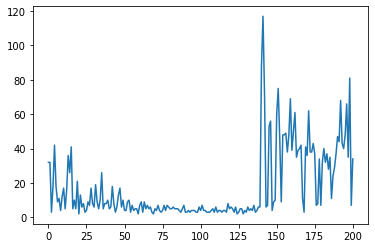

Episodes Done 300

[32.0, 32.0, 3.0, 18.0, 42.0, 18.0, 9.0, 11.0, 4.0, 12.0, 17.0, 5.0, 16.0, 36.0, 26.0, 41.0, 5.0, 10.0, 5.0, 21.0, 2.0, 13.0, 6.0, 8.0, 3.0, 4.0, 9.0, 7.0, 17.0, 8.0, 6.0, 19.0, 9.0, 5.0, 10.0, 26.0, 5.0, 8.0, 8.0, 10.0, 5.0, 6.0, 18.0, 8.0, 3.0, 6.0, 13.0, 17.0, 6.0, 10.0, 4.0, 4.0, 9.0, 10.0, 3.0, 7.0, 4.0, 5.0, 5.0, 2.0, 7.0, 9.0, 3.0, 9.0, 5.0, 7.0, 5.0, 6.0, 3.0, 2.0, 5.0, 4.0, 7.0, 4.0, 3.0, 4.0, 7.0, 4.0, 7.0, 6.0, 5.0, 5.0, 6.0, 5.0, 5.0, 5.0, 4.0, 3.0, 5.0, 7.0, 3.0, 3.0, 4.0, 3.0, 4.0, 4.0, 4.0, 3.0, 3.0, 6.0, 4.0, 7.0, 4.0, 4.0, 3.0, 3.0, 3.0, 4.0, 5.0, 3.0, 6.0, 3.0, 4.0, 4.0, 3.0, 4.0, 4.0, 3.0, 8.0, 5.0, 6.0, 5.0, 3.0, 6.0, 2.0, 3.0, 5.0, 5.0, 2.0, 4.0, 3.0, 6.0, 4.0, 5.0, 4.0, 7.0, 3.0, 4.0, 6.0, 6.0, 88.0, 117.0, 72.0, 6.0, 7.0, 53.0, 56.0, 4.0, 9.0, 10.0, 60.0, 75.0, 46.0, 9.0, 48.0, 48.0, 49.0, 38.0, 48.0, 69.0, 39.0, 50.0, 61.0, 35.0, 39.0, 40.0, 42.0, 11.0, 3.0, 41.0, 36.0, 62.0, 38.0, 38.0, 43.0, 37.0, 7.0, 8.0, 34.0, 7.0, 32.0, 40.0, 32.0, 37.0,

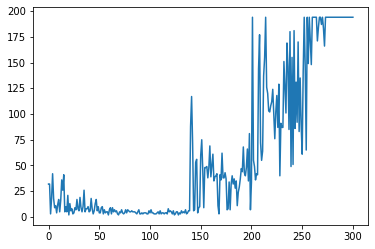

Episodes Done 400

[32.0, 32.0, 3.0, 18.0, 42.0, 18.0, 9.0, 11.0, 4.0, 12.0, 17.0, 5.0, 16.0, 36.0, 26.0, 41.0, 5.0, 10.0, 5.0, 21.0, 2.0, 13.0, 6.0, 8.0, 3.0, 4.0, 9.0, 7.0, 17.0, 8.0, 6.0, 19.0, 9.0, 5.0, 10.0, 26.0, 5.0, 8.0, 8.0, 10.0, 5.0, 6.0, 18.0, 8.0, 3.0, 6.0, 13.0, 17.0, 6.0, 10.0, 4.0, 4.0, 9.0, 10.0, 3.0, 7.0, 4.0, 5.0, 5.0, 2.0, 7.0, 9.0, 3.0, 9.0, 5.0, 7.0, 5.0, 6.0, 3.0, 2.0, 5.0, 4.0, 7.0, 4.0, 3.0, 4.0, 7.0, 4.0, 7.0, 6.0, 5.0, 5.0, 6.0, 5.0, 5.0, 5.0, 4.0, 3.0, 5.0, 7.0, 3.0, 3.0, 4.0, 3.0, 4.0, 4.0, 4.0, 3.0, 3.0, 6.0, 4.0, 7.0, 4.0, 4.0, 3.0, 3.0, 3.0, 4.0, 5.0, 3.0, 6.0, 3.0, 4.0, 4.0, 3.0, 4.0, 4.0, 3.0, 8.0, 5.0, 6.0, 5.0, 3.0, 6.0, 2.0, 3.0, 5.0, 5.0, 2.0, 4.0, 3.0, 6.0, 4.0, 5.0, 4.0, 7.0, 3.0, 4.0, 6.0, 6.0, 88.0, 117.0, 72.0, 6.0, 7.0, 53.0, 56.0, 4.0, 9.0, 10.0, 60.0, 75.0, 46.0, 9.0, 48.0, 48.0, 49.0, 38.0, 48.0, 69.0, 39.0, 50.0, 61.0, 35.0, 39.0, 40.0, 42.0, 11.0, 3.0, 41.0, 36.0, 62.0, 38.0, 38.0, 43.0, 37.0, 7.0, 8.0, 34.0, 7.0, 32.0, 40.0, 32.0, 37.0,

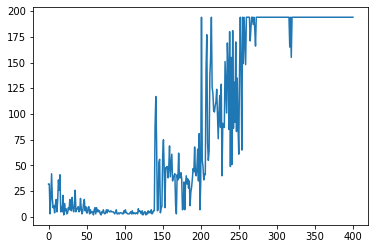

Episodes Done 500

[32.0, 32.0, 3.0, 18.0, 42.0, 18.0, 9.0, 11.0, 4.0, 12.0, 17.0, 5.0, 16.0, 36.0, 26.0, 41.0, 5.0, 10.0, 5.0, 21.0, 2.0, 13.0, 6.0, 8.0, 3.0, 4.0, 9.0, 7.0, 17.0, 8.0, 6.0, 19.0, 9.0, 5.0, 10.0, 26.0, 5.0, 8.0, 8.0, 10.0, 5.0, 6.0, 18.0, 8.0, 3.0, 6.0, 13.0, 17.0, 6.0, 10.0, 4.0, 4.0, 9.0, 10.0, 3.0, 7.0, 4.0, 5.0, 5.0, 2.0, 7.0, 9.0, 3.0, 9.0, 5.0, 7.0, 5.0, 6.0, 3.0, 2.0, 5.0, 4.0, 7.0, 4.0, 3.0, 4.0, 7.0, 4.0, 7.0, 6.0, 5.0, 5.0, 6.0, 5.0, 5.0, 5.0, 4.0, 3.0, 5.0, 7.0, 3.0, 3.0, 4.0, 3.0, 4.0, 4.0, 4.0, 3.0, 3.0, 6.0, 4.0, 7.0, 4.0, 4.0, 3.0, 3.0, 3.0, 4.0, 5.0, 3.0, 6.0, 3.0, 4.0, 4.0, 3.0, 4.0, 4.0, 3.0, 8.0, 5.0, 6.0, 5.0, 3.0, 6.0, 2.0, 3.0, 5.0, 5.0, 2.0, 4.0, 3.0, 6.0, 4.0, 5.0, 4.0, 7.0, 3.0, 4.0, 6.0, 6.0, 88.0, 117.0, 72.0, 6.0, 7.0, 53.0, 56.0, 4.0, 9.0, 10.0, 60.0, 75.0, 46.0, 9.0, 48.0, 48.0, 49.0, 38.0, 48.0, 69.0, 39.0, 50.0, 61.0, 35.0, 39.0, 40.0, 42.0, 11.0, 3.0, 41.0, 36.0, 62.0, 38.0, 38.0, 43.0, 37.0, 7.0, 8.0, 34.0, 7.0, 32.0, 40.0, 32.0, 37.0,

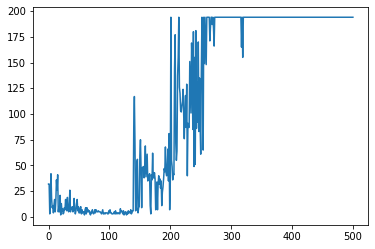

Episodes Done 600

[32.0, 32.0, 3.0, 18.0, 42.0, 18.0, 9.0, 11.0, 4.0, 12.0, 17.0, 5.0, 16.0, 36.0, 26.0, 41.0, 5.0, 10.0, 5.0, 21.0, 2.0, 13.0, 6.0, 8.0, 3.0, 4.0, 9.0, 7.0, 17.0, 8.0, 6.0, 19.0, 9.0, 5.0, 10.0, 26.0, 5.0, 8.0, 8.0, 10.0, 5.0, 6.0, 18.0, 8.0, 3.0, 6.0, 13.0, 17.0, 6.0, 10.0, 4.0, 4.0, 9.0, 10.0, 3.0, 7.0, 4.0, 5.0, 5.0, 2.0, 7.0, 9.0, 3.0, 9.0, 5.0, 7.0, 5.0, 6.0, 3.0, 2.0, 5.0, 4.0, 7.0, 4.0, 3.0, 4.0, 7.0, 4.0, 7.0, 6.0, 5.0, 5.0, 6.0, 5.0, 5.0, 5.0, 4.0, 3.0, 5.0, 7.0, 3.0, 3.0, 4.0, 3.0, 4.0, 4.0, 4.0, 3.0, 3.0, 6.0, 4.0, 7.0, 4.0, 4.0, 3.0, 3.0, 3.0, 4.0, 5.0, 3.0, 6.0, 3.0, 4.0, 4.0, 3.0, 4.0, 4.0, 3.0, 8.0, 5.0, 6.0, 5.0, 3.0, 6.0, 2.0, 3.0, 5.0, 5.0, 2.0, 4.0, 3.0, 6.0, 4.0, 5.0, 4.0, 7.0, 3.0, 4.0, 6.0, 6.0, 88.0, 117.0, 72.0, 6.0, 7.0, 53.0, 56.0, 4.0, 9.0, 10.0, 60.0, 75.0, 46.0, 9.0, 48.0, 48.0, 49.0, 38.0, 48.0, 69.0, 39.0, 50.0, 61.0, 35.0, 39.0, 40.0, 42.0, 11.0, 3.0, 41.0, 36.0, 62.0, 38.0, 38.0, 43.0, 37.0, 7.0, 8.0, 34.0, 7.0, 32.0, 40.0, 32.0, 37.0,

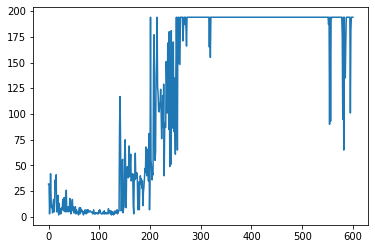

Episodes Done 700

[32.0, 32.0, 3.0, 18.0, 42.0, 18.0, 9.0, 11.0, 4.0, 12.0, 17.0, 5.0, 16.0, 36.0, 26.0, 41.0, 5.0, 10.0, 5.0, 21.0, 2.0, 13.0, 6.0, 8.0, 3.0, 4.0, 9.0, 7.0, 17.0, 8.0, 6.0, 19.0, 9.0, 5.0, 10.0, 26.0, 5.0, 8.0, 8.0, 10.0, 5.0, 6.0, 18.0, 8.0, 3.0, 6.0, 13.0, 17.0, 6.0, 10.0, 4.0, 4.0, 9.0, 10.0, 3.0, 7.0, 4.0, 5.0, 5.0, 2.0, 7.0, 9.0, 3.0, 9.0, 5.0, 7.0, 5.0, 6.0, 3.0, 2.0, 5.0, 4.0, 7.0, 4.0, 3.0, 4.0, 7.0, 4.0, 7.0, 6.0, 5.0, 5.0, 6.0, 5.0, 5.0, 5.0, 4.0, 3.0, 5.0, 7.0, 3.0, 3.0, 4.0, 3.0, 4.0, 4.0, 4.0, 3.0, 3.0, 6.0, 4.0, 7.0, 4.0, 4.0, 3.0, 3.0, 3.0, 4.0, 5.0, 3.0, 6.0, 3.0, 4.0, 4.0, 3.0, 4.0, 4.0, 3.0, 8.0, 5.0, 6.0, 5.0, 3.0, 6.0, 2.0, 3.0, 5.0, 5.0, 2.0, 4.0, 3.0, 6.0, 4.0, 5.0, 4.0, 7.0, 3.0, 4.0, 6.0, 6.0, 88.0, 117.0, 72.0, 6.0, 7.0, 53.0, 56.0, 4.0, 9.0, 10.0, 60.0, 75.0, 46.0, 9.0, 48.0, 48.0, 49.0, 38.0, 48.0, 69.0, 39.0, 50.0, 61.0, 35.0, 39.0, 40.0, 42.0, 11.0, 3.0, 41.0, 36.0, 62.0, 38.0, 38.0, 43.0, 37.0, 7.0, 8.0, 34.0, 7.0, 32.0, 40.0, 32.0, 37.0,

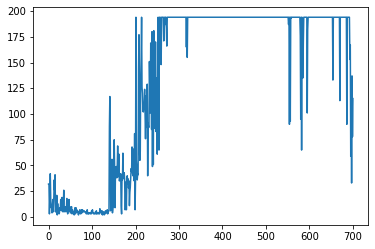

In [ ]:
agent = run_config(config,'CartPole-v0', 'ddqn')

Comments: The agent is able to learn a perfect Q function as it consistently gets the maximum reward from episodes 320 - 500, then there is some aberration in the reward mostly due to epsilon and overfitting.

**DDQN Improvements**

DDQN improves the overestimation of rewards as compared to DQN. This is its main improvement over DQN.

DDQN converges faster, it took around 250 epochs for DDQN to solve the environment whereas it took around 500 epochs for DQN .The convergence is better with lesser noise in the reward plots for DDQN as compared to DQN.